# Understanding the Data 




In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random
import itertools

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,multilabel_confusion_matrix
from sklearn.utils import class_weight



import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,LSTM,GRU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input,Dropout,Bidirectional,SpatialDropout1D
from tensorflow.keras.layers import TimeDistributed




In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd "/gdrive/MyDrive/Colab Notebooks/kaggle/ner"

/gdrive/MyDrive/Colab Notebooks/kaggle/ner


In [4]:
# data_features=pd.read_csv('ner.csv',encoding="ISO-8859-1" ,error_bad_lines=False)
data=pd.read_csv("ner_dataset.csv",encoding="ISO-8859-1")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [6]:
# data_features.info()

In [7]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [8]:
data.columns=['Sentence', 'Word', 'POS', 'Tag']


In [9]:
data.Sentence.fillna(method="pad",inplace=True)

In [10]:
data.Sentence=data.Sentence.apply(lambda x: x[10:]).astype(int)

In [11]:
data.Sentence.max()

47959

In [12]:
words=list(set([i for i in data.Word.values ]))
tags=list(set([i for i in data.Tag.values ]))
word2ind={tag:i+1 for i , tag in enumerate(words)}
tag2ind={tag:i+1 for i , tag in enumerate(tags)}
word2ind.update({"pad":0})
tag2ind.update({"pad":0})

ind2word={i:tag for tag, i in word2ind.items()}
ind2tag={i:tag for tag, i in tag2ind.items()}

In [13]:
len(words),len(tags)


(35178, 17)

In [14]:
# there are 47959 sentences in total

In [15]:
def preprocess_data():
    dataset=[]
    X=[]
    y=[]
    for index in range(1,data.Sentence.max()+1):
        sentence=data[data.Sentence == index]
        dataset.append(list(zip(sentence.Word.values,sentence.Tag.values)))
        X.append(sentence.Word.values.tolist())
        y.append(sentence.Tag.tolist())
    return dataset,X,y

In [16]:
dataset,X,y=preprocess_data()

In [17]:
print(X[0],y[0])
# dataset[:20]

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [18]:
max_sec= max([len(sen) for sen in X])
print("max length of a sentence: ",max_sec)

max length of a sentence:  104


In [55]:
# word_tok=Tokenizer()
# word_tok.fit_on_texts(X)
# X_encoded=word_tok.texts_to_sequences(X)

# # tag_tok=Tokenizer()
# # tag_tok.fit_on_texts(y)
# # y_encoded=tag_tok.texts_to_sequences(y)

X_encoded=[[word2ind[word] for word in sen]for sen in X]
y_encoded=[[tag2ind[word] for word in sen]for sen in y]

In [56]:
print(y[0])
print(y_encoded[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[12, 12, 12, 12, 12, 12, 17, 12, 12, 12, 12, 12, 17, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12]


In [57]:
# pad sequence

In [58]:
X_padded = pad_sequences(X_encoded, maxlen=max_sec, padding="post",value=0)
y_padded = pad_sequences(y_encoded, maxlen=max_sec, padding="post",value=0)
# y_padded = pad_sequences(y_encoded, maxlen=max_sec, padding="post",value=-101)
# # one-hot encoding
# y_padded=np.array([to_categorical(i, num_classes = len(tags)) for i in y_padded])
y_padded=to_categorical(y_padded)


In [59]:
print('X shape', X_padded.shape, 'y shape', y_padded.shape)

X shape (47959, 104) y shape (47959, 104, 18)


In [60]:
# X,y=X_padded,y_padded

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.1, random_state=42)

In [167]:
len(X_train),len(X_test)

(43163, 4796)

In [168]:
X_train.shape

(43163, 104)

In [169]:
# rnn
VOCABULARY_SIZE = len(word2ind.values()) + 1
EMBEDDING_VECTOR_LENGTH =64
OUTPUT_SIZE=len(tags)+1
MAX_SEQ_LENGTH=max_sec



In [170]:

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_VECTOR_LENGTH,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False    ,                # False - don't update the embeddings
                        mask_zero=True
))

# # add an RNN layer which contains 64 RNN cells
# rnn_model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2,
                   
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# )))
# rnn_model.add(SpatialDropout1D(0.2))

# rnn_model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2,
                  
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# )))
# rnn_model.add(SpatialDropout1D(0.2))

# rnn_model.add(SimpleRNN(512, recurrent_dropout=0.3,
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# ))
# rnn_model.add(Dropout(0.3))

rnn_model.add(Bidirectional(GRU(128,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
)))
rnn_model.add(Bidirectional(GRU(256,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
)))
rnn_model.add(Bidirectional(GRU(512,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
)))
# rnn_model.add(CuDNNLSTM(16,   kernel_regularizer=regularizers.l2(0.1),
#                                          recurrent_regularizer=regularizers.l2(0.1),
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# ))
# rnn_model.add(CuDNNLSTM(6,  kernel_regularizer=regularizers.l2(0.01),
#                                          recurrent_regularizer=regularizers.l2(0.01),
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# ))
# rnn_model.add(Dropout(0.2))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(OUTPUT_SIZE, activation='softmax')))

In [171]:
def custom_loss(y_true, y_pred):
    class_weights =class_weight.compute_class_weight('balanced',
                                                list(ind2tag.values()),
                                                 [ind2tag[np.argmax(i)] for rand in range(len(y_padded)) for i in  y_padded[rand]])
                                                 
    cross_entropy = tf.reduce_mean(
        tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=class_weights))
            
        
    return cross_entropy

In [172]:
rnn_model.compile(loss      =  'categorical_crossentropy',
# rnn_model.compile(loss      =  custom_loss,
                  optimizer =  'adam',
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [173]:
# check summary of the model
rnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 104, 256)          148992    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 104, 512)          789504    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 104, 1024)         3151872   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 104, 18)           18450     
Total params: 6,360,274
Trainable params: 4,108,818
Non-trainable params: 2,251,456
_________________________________________________________________


In [174]:

rnn_training = rnn_model.fit(X_train, y_train,validation_split=0.2, batch_size=128, epochs=10, use_multiprocessing=True)

Epoch 1/10
270/270 [==============================] - 46s 103ms/step - loss: 0.1928 - categorical_accuracy: 0.8292 - val_loss: 0.1173 - val_categorical_accuracy: 0.8596
Epoch 2/10
270/270 [==============================] - 22s 82ms/step - loss: 0.1132 - categorical_accuracy: 0.8663 - val_loss: 0.1007 - val_categorical_accuracy: 0.8774
Epoch 3/10
270/270 [==============================] - 22s 83ms/step - loss: 0.0978 - categorical_accuracy: 0.8810 - val_loss: 0.0899 - val_categorical_accuracy: 0.8887
Epoch 4/10
270/270 [==============================] - 23s 84ms/step - loss: 0.0876 - categorical_accuracy: 0.8915 - val_loss: 0.0814 - val_categorical_accuracy: 0.8974
Epoch 5/10
270/270 [==============================] - 23s 84ms/step - loss: 0.0784 - categorical_accuracy: 0.9020 - val_loss: 0.0741 - val_categorical_accuracy: 0.9078
Epoch 6/10
270/270 [==============================] - 23s 83ms/step - loss: 0.0689 - categorical_accuracy: 0.9131 - val_loss: 0.0671 - val_categorical_accuracy

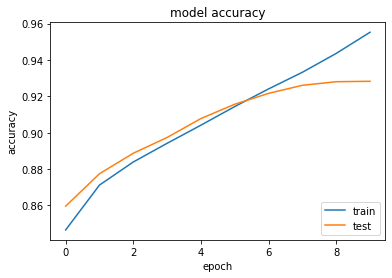

In [175]:
plt.plot(rnn_training.history['categorical_accuracy'])
plt.plot(rnn_training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [176]:
pred=rnn_model.predict(X_test)

# pred.shape




In [177]:
print(classification_report([ind2tag[np.argmax(i)] for rand in range(len(y_test)) for i in  y_test[rand]],[ind2tag[np.argmax(i)] for rand in range(len(y_test)) for i in  pred[rand]]))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        41
       B-eve       0.25      0.08      0.12        26
       B-geo       0.81      0.68      0.74      3894
       B-gpe       0.79      0.70      0.75      1542
       B-nat       0.67      0.14      0.24        28
       B-org       0.62      0.49      0.55      1988
       B-per       0.71      0.61      0.66      1696
       B-tim       0.86      0.74      0.79      2035
       I-art       0.00      0.00      0.00        25
       I-eve       0.00      0.00      0.00        23
       I-geo       0.82      0.60      0.69       764
       I-gpe       0.67      0.35      0.46        17
       I-nat       0.00      0.00      0.00         6
       I-org       0.67      0.52      0.59      1685
       I-per       0.74      0.72      0.73      1722
       I-tim       0.77      0.43      0.55       655
           O       0.18      0.98      0.30     87614
         pad       0.00    

In [178]:
rnn_model.evaluate(X_test,y_test)

150/150 [==============================] - 2s 15ms/step - loss: 0.0575 - categorical_accuracy: 0.9276


[0.05753250792622566, 0.9275835752487183]

In [179]:
# test a seq

In [180]:
rand=np.random.randint(0,X_test.shape[0])
print(rand)
print([ind2word[i]  for i in  X_test[rand]])
print([ind2tag[np.argmax(i)] for i in  y_test[rand]])
print([ind2tag[np.argmax(i)] for i in  pred[rand]])

1810
['Somalia', 'has', 'been', 'without', 'a', 'central', 'government', 'for', '14', 'years', ',', 'having', 'been', 'ruled', 'by', 'warring', 'factional', 'leaders', '.', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'p